In [1]:
import pymc3 as pm
import numpy as np
from pymc3 import gp
import matplotlib.pyplot as plt
import theano.tensor as tt
%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(pm.__version__)

3.4.1


## Trying a regression using Gaussian Processes

In [3]:
num_points = 200
x = np.linspace(-10, 10, num = num_points).reshape(-1,1)
noise = np.random.normal(loc = 10, scale = 80, size = num_points).reshape(-1,1)
y = x**3 + noise

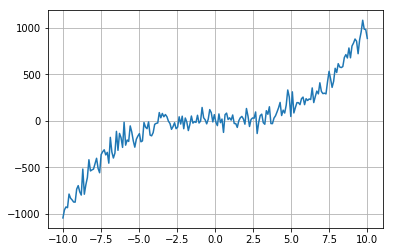

In [4]:
plt.plot(x, y)
plt.grid()

In [5]:
lengthscale = 0.3

In [6]:
## Define mean and covariance function
cov_func = gp.cov.ExpQuad(1,lengthscale)
mean_func = gp.mean.Constant(c=0)

In [7]:
K = cov_func(x)
Ks = cov_func(x,y)
K_noise = K + noise

In [8]:
# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

In [9]:
from pymc3.gp import cov, Latent
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat, Binomial, Exponential, HalfNormal
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit, invlogit
from pymc3.gp.util import plot_gp_dist
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cmap

import theano.tensor as tt
from theano import shared
import theano

sns.set_context('talk')

# Matern $\nu=3/2$ covariance

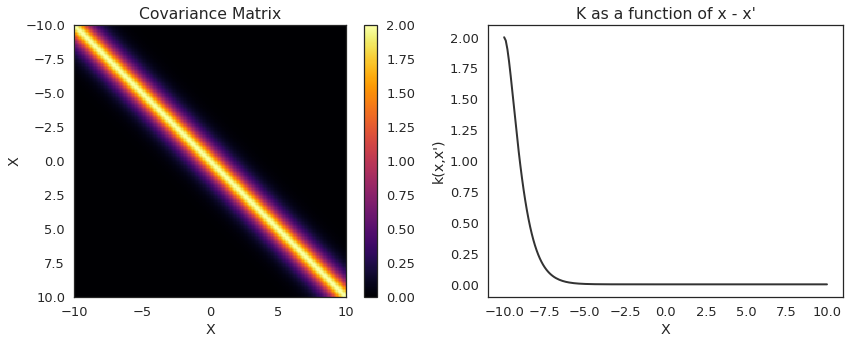

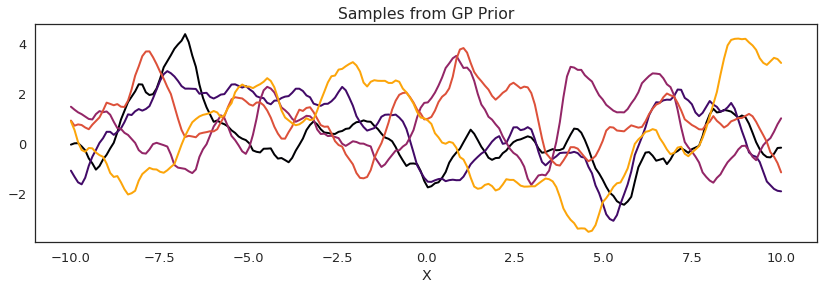

In [10]:
with pm.Model() as model:
    l = 1
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1,l)

K = theano.function([], cov(x))()

plot_cov(x, K)

## Cosine covariance

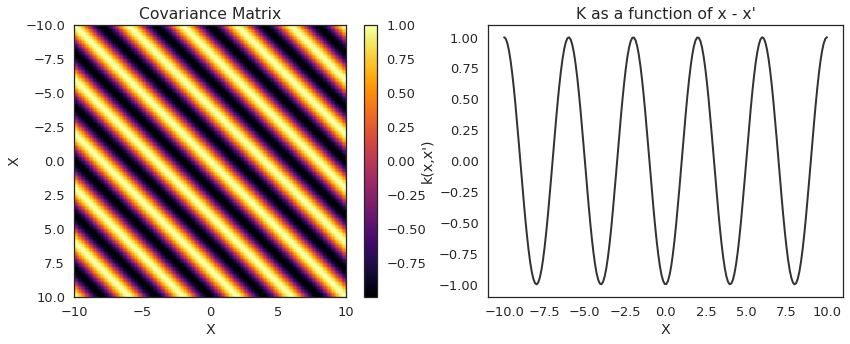

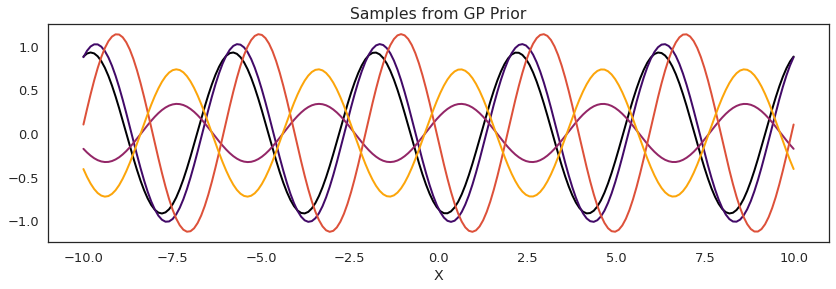

In [11]:
with pm.Model() as model:
    l = 0.02
    tau = 1.0
    cov = tau * pm.gp.cov.Cosine(1,l)
K = theano.function([], cov(x))()
plot_cov(x, K)

## Multiplication of different Covariance Functions

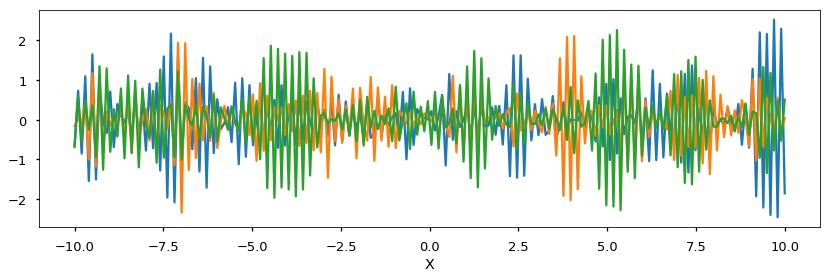

In [12]:
#first evaluate a covariance function into a matrix
period = 0.2
cov_cos = pm.gp.cov.Cosine(1, period)
K_cos = theano.function([], cov_cos(x))()

# now multiply it with a covariance *function*
cov = pm.gp.cov.Matern32(1, 0.5) * K_cos

X = np.linspace(0, 2, 200)[:,None]
K = cov(x).eval()

plt.figure(figsize=(14,4))
plt.plot(x, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

## Input waveform

In [74]:
num_points = 40
x = np.linspace(-10, 10, num = num_points).reshape(-1,1)
noise = np.random.normal(loc = 0.5, scale = 2, size = num_points).reshape(-1,1)
#y = x**3 + noise
y = 10* np.cos(x) + noise

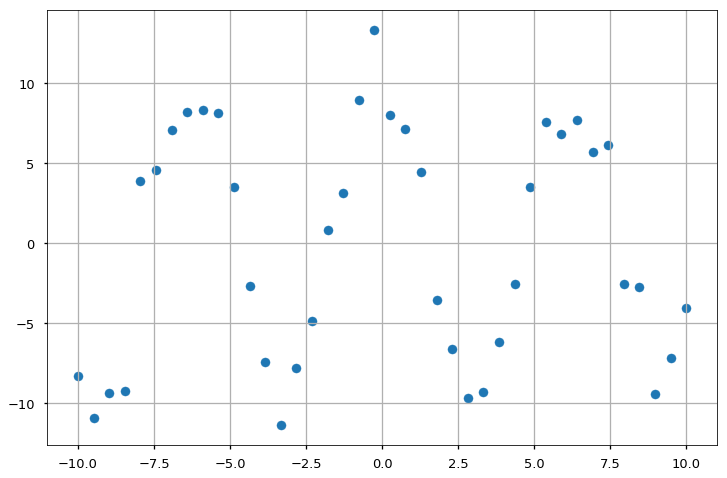

In [75]:
plt.figure(figsize=(12,8))
plt.scatter(x,y)
plt.grid()

In [76]:
y = y.squeeze(1)

In [77]:
x.shape, y.shape

((40, 1), (40,))

In [78]:
with pm.Model() as fit_model:

    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    
    ## Mean
    M = pm.gp.mean.Zero()
    
    ## Covariance
    cov = η * pm.gp.cov.ExpQuad(1, ρ) 
    
    #M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    #K = η * pm.gp.cov.ExpQuad(1, ρ) 
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    
    noise_sig = pm.HalfCauchy('σ', 2.5)
    likelyhood = gp.marginal_likelihood('likelyhood', 
                                      X=x, 
                                      y=y, 
                                      noise=noise_sig**2)

In [79]:
with fit_model:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, step, start=start)
    #fit_trace = pm.sample(1000, tune=2000)

logp = -116.55, ||grad|| = 2.4628e-06: 100%|██████████| 42/42 [00:00<00:00, 519.08it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, η_log__, ρ_log__]
100%|██████████| 5500/5500 [00:35<00:00, 153.51it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8905580215216747, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [80]:
test_range = np.linspace(-30, 30, 100).reshape(-1, 1)

In [81]:
with fit_model:
    fit_pred = gp.conditional("fit_pred", test_range)
    fit_samples = pm.sample_ppc(trace, vars=[fit_pred], samples=4000)

100%|██████████| 4000/4000 [00:13<00:00, 291.14it/s]


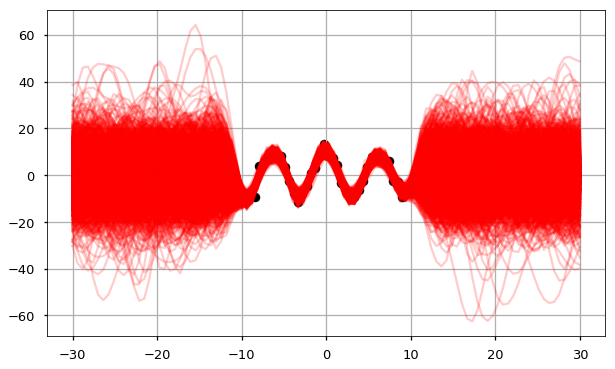

In [82]:
plt.figure(figsize = (10,6))
plt.scatter(x,y,c='k')
for sample in fit_samples['fit_pred']:
    plt.plot(test_range,sample, color = 'r', alpha = 0.2)
plt.grid()

## using Different covariance Kernel

In [69]:
with pm.Model() as fit_model_2:
    
    #η = pm.HalfCauchy('η', 15)
    #period = 0.025
    ls = 0.2
    
    ## Mean
    M = pm.gp.mean.Constant(0)
    #cov = 30* pm.gp.cov.Cosine(1, period)
    cov = pm.gp.cov.Matern32(1,ls)
    
    ## Gaussian Process
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    
    ## Noise and Likelihood
    noise_sig = pm.HalfCauchy('σ', 2.5)
    likelyhood = gp.marginal_likelihood('likelyhood', 
                                      X=x, 
                                      y=y, 
                                      noise=noise_sig**2)

In [70]:
with fit_model_2:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_2 = pm.sample(5000, step, start=start)

logp = -143.42, ||grad|| = 40.782: 100%|██████████| 8/8 [00:00<00:00, 720.53it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__]
100%|██████████| 5500/5500 [00:17<00:00, 315.33it/s]


### Sample from trained model

In [73]:
test_range = np.linspace(-30, 30, 100).reshape(-1, 1)
with fit_model_2:
    fit_pred_2 = gp.conditional("fit_pred_2", test_range)
    fit_samples_2 = pm.sample_ppc(trace_2, vars=[fit_pred_2], samples=50)

ValueError: Variable name fit_pred_2 already exists.

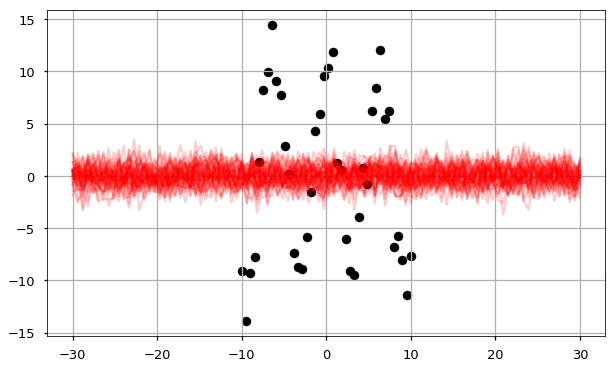

In [72]:
plt.figure(figsize = (10,6))
plt.scatter(x,y,c='k')
for sample in fit_samples_2['fit_pred_2']:
    plt.plot(test_range,sample, color = 'r', alpha = 0.2)
plt.grid()

## Salmon Data

In [ ]:
import pandas as pd

In [ ]:
!ls ../../learn/bayesian_mixer_london_2017/data

In [ ]:
salmon_data = pd.read_table('../../learn/bayesian_mixer_london_2017/data/salmon.txt', sep='\s+', index_col=0)
salmon_data

In [ ]:
x = salmon_data['spawners']
y = salmon_data['recruits']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid(ls = 'dotted')

In [ ]:
x = x.values.reshape(-1,1)
x.shape, y.shape

In [ ]:
X = x.values.reshape(-1,1)
y = y.values
X.shape, y.shape

In [ ]:
with pm.Model() as salmon_model:

    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = η * pm.gp.cov.ExpQuad(1, ρ) 
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    
    σ = pm.HalfCauchy('σ', 2.5)
    recruits = gp.marginal_likelihood('recruits', 
                                      X=X, 
                                      y=y, 
                                      noise=σ**2)

In [ ]:
with salmon_model:
    salmon_trace = pm.sample(1000, tune=2000)

In [ ]:
spawner_range = np.linspace(0, 1000, 100).reshape(-1, 1)

In [ ]:
spawner_range.shape

In [ ]:
with salmon_model:
    salmon_pred = gp.conditional("salmon_pred", spawner_range)
    salmon_samples = pm.sample_ppc(salmon_trace, vars=[salmon_pred], samples=20)

In [ ]:
print(len(salmon_samples['salmon_pred']))

In [ ]:
x.size, y.size

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x,y,c='k')
for sample in salmon_samples['salmon_pred']:
    plt.plot(spawner_range,sample, color = 'r', alpha = 0.2)
plt.grid()